In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd

plt.style.use('ggplot')
pd.set_option('display.max_columns', 30)

In [2]:
df = pd.read_csv('data/citibike_ZIP.csv')
df.head()

,tripduration,starttime,stoptime,start_id,start_name,start_lat,start_lon,end_id,end_name,end_lat,end_lon,bikeid,usertype,birth_year,gender,weekday,hour,geometry,zip_start,zip_end
0,17.700000,2020-06-01 00:00:03.372,2020-06-01 00:17:46.208,3419,Douglass St & 4 Ave,40.679279,-73.981540,3419,Douglass St & 4 Ave,40.679279,-73.981540,39852,Customer,1997,2,0,0,POINT (989370.1838770027 186756.53892500512),11217,11217.0
1,63.500000,2020-06-01 00:00:03.553,2020-06-01 01:03:33.936,366,Clinton Ave & Myrtle Ave,40.693261,-73.968896,336,Sullivan St & Washington Sq,40.730477,-73.999061,37558,Subscriber,1969,0,0,0,POINT (992875.4144866021 191851.65323921342),11205,10012.0
2,16.950000,2020-06-01 00:00:09.614,2020-06-01 00:17:06.833,389,Broadway & Berry St,40.710446,-73.965251,3562,Classon Ave & St Marks Ave,40.676520,-73.959608,37512,Customer,1988,2,0,0,POINT (993883.8241576733 198112.87322040228),11249,11238.0
3,3.766667,2020-06-01 00:00:12.178,2020-06-01 00:03:58.864,3255,8 Ave & W 31 St,40.750585,-73.994685,505,6 Ave & W 33 St,40.749013,-73.988484,39674,Customer,1969,0,0,0,POINT (985722.6805079061 212735.19209770544),10001,10001.0
4,23.950000,2020-06-01 00:00:21.255,2020-06-01 00:24:18.965,367,E 53 St & Lexington Ave,40.758281,-73.970694,497,E 17 St & Broadway,40.737050,-73.990093,21093,Customer,1997,2,0,0,POINT (992368.8021711168 215540.1540624901),10022,10003.0


In [3]:
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

In [5]:
# supply and demand

starts_hrly = df.groupby(['hour','start_id'], as_index = False)[['starttime']].count()
starts_hrly.columns = ['hour','start_id','start_count']
starts_hrly

,hour,start_id,start_count
0,0,72,45
1,0,79,11
2,0,82,4
3,0,83,35
4,0,116,32
...,...,...,...
22045,23,4020,45
22046,23,4023,26
22047,23,4036,19
22048,23,4037,5


In [6]:
ends_hrly = df.groupby(['hour','end_id'], as_index = False)[['starttime']].count()
ends_hrly.columns = ['hour','end_id','end_count']
ends_hrly

,hour,end_id,end_count
0,0,72,53
1,0,79,8
2,0,82,10
3,0,83,17
4,0,116,40
...,...,...,...
22065,23,4021,1
22066,23,4023,40
22067,23,4036,11
22068,23,4037,8


In [7]:
supply_hrly = starts_hrly.merge(ends_hrly,
                               left_on = ['hour','start_id'],
                               right_on = ['hour','end_id'],
                               how = 'outer')
supply_hrly.head(10)

,hour,start_id,start_count,end_id,end_count
0,0,72.0,45.0,72.0,53.0
1,0,79.0,11.0,79.0,8.0
2,0,82.0,4.0,82.0,10.0
3,0,83.0,35.0,83.0,17.0
4,0,116.0,32.0,116.0,40.0
5,0,119.0,23.0,119.0,21.0
6,0,120.0,14.0,120.0,7.0
7,0,127.0,39.0,127.0,20.0
8,0,128.0,72.0,128.0,62.0
9,0,143.0,19.0,143.0,19.0


In [8]:
supply_hrly['end_count'].fillna(0, inplace=True)
supply_hrly['start_count'].fillna(0, inplace=True)

In [9]:
# define hourly surplus as the difference between hourly end count and start count at a station
# find daily average by dividing by 30

supply_hrly['hrly_surplus'] = (supply_hrly['end_count'] - supply_hrly['start_count'])/30
supply_hrly.head()

,hour,start_id,start_count,end_id,end_count,hrly_surplus
0,0,72.0,45.0,72.0,53.0,0.266667
1,0,79.0,11.0,79.0,8.0,-0.100000
2,0,82.0,4.0,82.0,10.0,0.200000
3,0,83.0,35.0,83.0,17.0,-0.600000
4,0,116.0,32.0,116.0,40.0,0.266667


In [10]:
pd.set_option('display.float_format', '{:.2f}'.format)
supply_hrly['hrly_surplus'].describe()

count   22558.00
mean        0.00
std         1.12
min       -25.13
25%        -0.27
50%         0.00
75%         0.27
max        36.70
Name: hrly_surplus, dtype: float64

In [102]:
supply_hrly[supply_hrly['hrly_surplus'] > 10]

,hour,start_id,start_count,end_id,end_count,hrly_surplus
5105,6,2012.00,99.00,2012.00,700.00,21.46
5191,6,3141.00,222.00,3141.00,1253.00,36.82
5203,6,3156.00,109.00,3156.00,564.00,16.25
5300,6,3345.00,50.00,3345.00,418.00,13.14
5536,6,3687.00,127.00,3687.00,704.00,20.61
6106,7,3141.00,837.00,3141.00,1258.00,15.04
6458,7,3687.00,335.00,3687.00,674.00,12.11
6962,8,2012.00,203.00,2012.00,484.00,10.04
7049,8,3141.00,693.00,3141.00,1047.00,12.64
7997,9,3141.00,383.00,3141.00,707.00,11.57


In [108]:
supply_hrly[supply_hrly['hrly_surplus'] < -10]

,hour,start_id,start_count,end_id,end_count,hrly_surplus
5058,6,492.00,399.00,492.00,47.00,-12.57
13706,15,3141.00,845.00,3141.00,452.00,-14.04
14571,16,2012.00,482.00,2012.00,155.00,-11.68
14658,16,3141.00,1212.00,3141.00,480.00,-26.14
15010,16,3687.00,618.00,3687.00,296.00,-11.50
15612,17,3141.00,1284.00,3141.00,613.00,-23.96


In [12]:
d = supply_hrly.groupby('hour', as_index = False)[['hrly_surplus']].agg(['mean','min','max'])
d = d['hrly_surplus'].reset_index()
d

,hour,mean,min,max
0,0,0.00,-2.97,1.20
1,1,-0.00,-1.07,0.93
2,2,0.00,-1.07,0.57
3,3,0.00,-0.53,0.50
4,4,-0.00,-0.63,1.17
5,5,-0.00,-7.80,6.47
6,6,-0.00,-11.87,36.70
7,7,0.00,-5.60,14.03
8,8,-0.00,-5.33,11.70
9,9,-0.00,-4.83,10.80


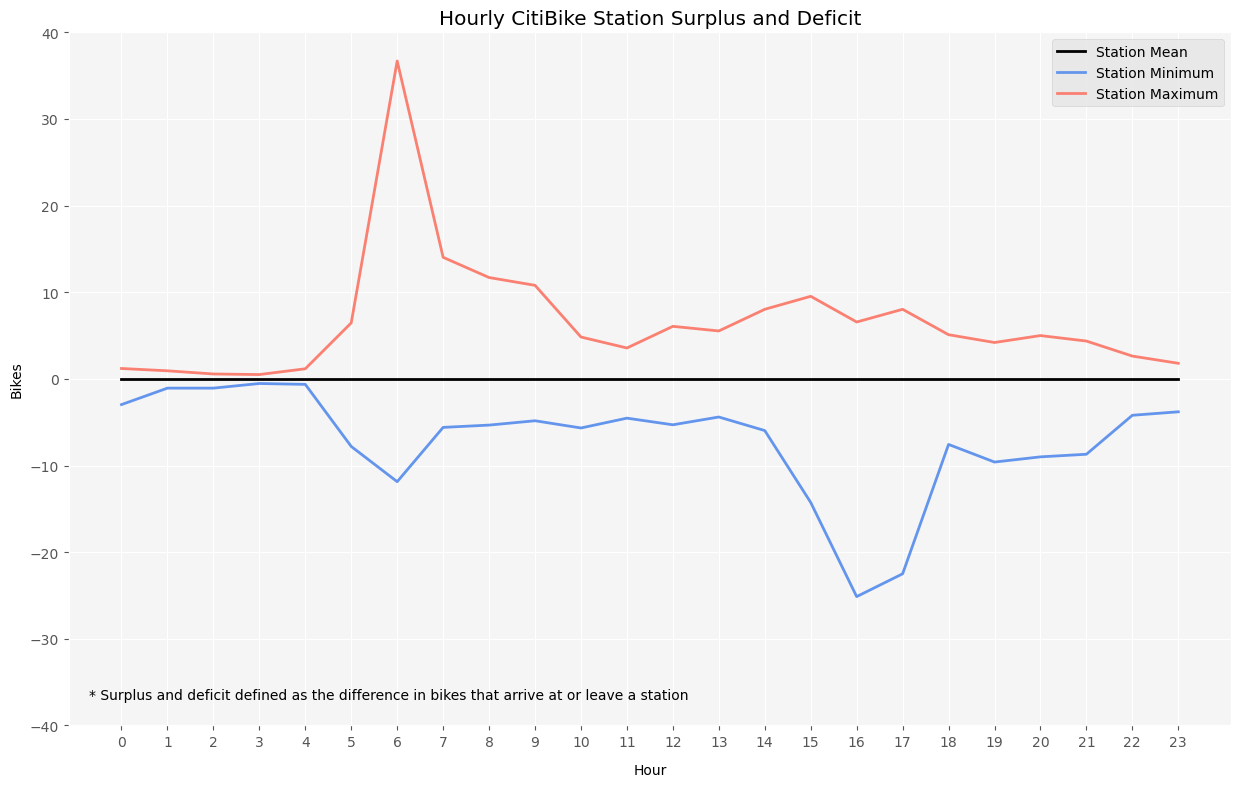

In [27]:
fig, ax = plt.subplots(figsize=(15,9))

x = np.arange(24)
  
d.plot(ax=ax, x = 'hour', y = 'mean', color = 'black', linewidth = 2)
d.plot(ax=ax, x = 'hour', y = 'min', color = 'cornflowerblue', linewidth = 2)
d.plot(ax=ax, x = 'hour', y = 'max', color = 'salmon', linewidth = 2)

plt.xticks(x)
plt.xlabel("Hour", labelpad = 10)
plt.ylim(-40, 40)
plt.ylabel("Bikes")
plt.text(-0.7, -37, '* Surplus and deficit defined as the difference in bikes that arrive at or leave a station')
plt.legend(['Station Mean', 'Station Minimum', 'Station Maximum'])

plt.title('Hourly CitiBike Station Surplus and Deficit')
ax.set_facecolor("whitesmoke")